In [503]:
import torch
from kemsekov_torch.train import load_best_checkpoint, load_last_checkpoint
from kemsekov_torch.flow_matching import FlowMatching
import torchvision.transforms as T
fm = FlowMatching()
path = 'runs/vae-tree/'
model = torch.jit.load(path+"/model.pt")
# model = load_last_checkpoint(model,path).eval().cuda()
model = load_best_checkpoint(model,path).eval().cuda()

loading runs/vae-tree/checkpoints/epoch-563/state


class 3


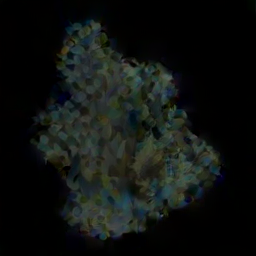

In [587]:
import random
from matplotlib import pyplot as plt
from vae import decode
guidance = 5
cls = random.randint(0,19)
# cls=9

x0 = torch.randn((1,4,32,32)).cuda()
print("class",cls)

cls = torch.Tensor([cls]).long().cuda()
def run_model(xt,t):
    pred_no_cls = model(xt,t,cls*0-1)
    pred_cls =  model(xt,t,cls)
    total = pred_no_cls+guidance*(pred_cls-pred_no_cls)
    return total

steps = 32
sample,intermediates = fm.sample(run_model,x0,steps,churn_scale=0.001,device='cuda',return_intermediates=True)
sample_dec = decode(sample)

T.ToPILImage()(sample_dec.clip(0,1)[0])